### Violence Detection using Stacked Ensemble

### Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Practice Module/Violence-Detection'

Mounted at /content/gdrive


In [ ]:
import os
import cv2
import sys
import h5py
import glob
import random
import numpy as np
import pandas as pd
from random import shuffle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.layers import Dense, Activation , Dropout
%matplotlib inline

## Helper Functions

We will use the function ```print_progress``` to print the amount of videos processed the datasets

In [ ]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

## Load Data

Firstly, we define the directory to read the video dataset

In [ ]:
img_dir = "../RWF-2000/train"      # This folder contains RGB videos
img_val = '../RWF-2000/val'

kp_dir = "../keypoints/train"      # This folder contains keypoint videos
kp_val = '../keypoints/val'

opt_dir = "../opt_flow/train"      # This folder contains optical flow videos
opt_val = "../opt_flow/val"

Copy some of the data-dimensions for convenience.

In [ ]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 100

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".avi"

### Helper-function for getting video frames
Function used to get 100 frames from a video file and convert the frame to a suitable format for the neural net.

In [ ]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)   
    images = []   
    vidcap = cv2.VideoCapture(in_file)   
    success,image = vidcap.read()      
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
        images.append(res)
        success,image = vidcap.read()
        count += 1
        
    resul = np.array(images)
    resul = (resul / 255.).astype(np.float16)
        
    return resul

In [ ]:
def label_video_names(sample_size=800, dir=kp_dir):
    
    # list containing video names
    fight, no_fight, names = [], [], []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    fi, no, labels = [], [], []
    # get equal number of fight and no fight
    n = sample_size//2
    # if n >= 450:
    #     n = 450
    
    for current_dir, dir_names,file_names in os.walk(dir):
        
        for file_name in file_names:       
            if file_name[0:2] == 'fi':
                fi.append([1,0])
                fight.append(file_name)
            elif file_name[0:2] == 'no':
                no.append([0,1])
                no_fight.append(file_name)
                     
    c_fi = list(zip(fight, fi))
    c_no = list(zip(no_fight, no))      
    #c = list(zip(names,labels))
    # Suffle the data (names and labels)
    #res = random.sample(c, sample_size)
    res_fi = random.sample(c_fi, len(c_fi))   # equal no of fi and no fi
    res_no = random.sample(c_no, len(c_no))
    res = res_fi + res_no
    res = random.sample(res, len(res))
    names, labels = zip(*res)
    
    return names, labels

## Pre-Trained Model: VGG16

The following creates an instance of the pre-trained VGG16 model using the Keras API. This automatically downloads the required files if you don't have them already.

The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for classification. If include_top=True then the whole VGG16 model is downloaded. If include_top=False then only the convolutional part of the VGG16 model is downloaded .

In [ ]:
vid_model = VGG16(include_top=True, weights='imagenet')

553476096/553467096 [==============================] - 11s 0us/step


Let's see the model summary

vid_model.summary()


We can observe the shape of the tensors expected as input by the pre-trained VGG16 model. In this case it is images of shape 224 x 224 x 3. Note that we have defined the frame size as 224x224x3. The video frame will be the input of the VGG16 net.

### VGG16 model flowchart

The following chart shows how the data flows when using the VGG16 model for Transfer Learning. First we input and process 100 video frames in batch with the VGG16 model. Just prior to the final classification layer of the VGG16 model, we save the so-called Transfer Values to a cache-file.


In [ ]:
# We will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = vid_model.get_layer('fc2')

image_model_transfer = Model(inputs=vid_model.input,
                             outputs=transfer_layer.output)
transfer_values_size = K.int_shape(transfer_layer.output)[1]

print("The input of the VGG16 net have dimensions:",K.int_shape(vid_model.input)[1:3])
print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


### Generator that process one video through VGG16 each function call

In [ ]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0  
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count] 
        image_batch = np.zeros(shape=shape, dtype=np.float16)
        
        try:
            image_batch = get_frames(in_dir, video_name)
        except:
          print('Error', video_name)
          continue
        
        # Note that we use 16 bit floating pt to save memory
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = image_model_transfer.predict(image_batch)       
        labels1 = labels[count]     
        aux = np.ones([100,2])   
        labelss = labels1*aux 
        yield transfer_values, labelss
        count+=1

### Functions to save transfer values from VGG16 to later use
We are going to define functions to get the transfer values from VGG16 with defined number of files. Then save the transfer values files used from training in one file and the ones uses for testing in another one. 

In [ ]:
def make_files_train(save_file, n_files):
    
    gen = proces_transfer(names_training, in_dir, labels_training)
    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File(save_file, 'w') as f:    # 'train_1000.h5'
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [ ]:
def make_files_test(save_file, n_files):
    
    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File(save_file, 'w') as f:    # save_file = 'validate_1000.h5'
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [ ]:
def process_data_train(save_h5_train):
    
    joint_transfer=[]
    frames_num=100
    count = 0
    
    with h5py.File(save_h5_train, 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [ ]:
def process_data_test(save_h5_val):
    
    joint_transfer=[]
    frames_num=100
    count = 0
    
    with h5py.File(save_h5_val, 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [ ]:
# First get the names and labels of the whole videos
names, labels = label_video_names(sample_size=800)

In [ ]:
val_names, val_labels = label_video_names(sample_size=800, dir=kp_dir)
fi, no = [], []
for name in val_names:
  if name[0:2] == 'fi':
    fi.append(name)
  else:
    no.append(name)
print(len(fi), len(no))


400 400


In [ ]:
# Create test set for images, keypoints and optical flow
for i in range (5):

    # First get the names and labels of the whole videos
    names, labels = label_video_names(sample_size=800)

    # Then get the list for training and test dataset
    training_set = int(len(names)*0.8)
    test_set = int(len(names)*0.2)

    names_training = names[0:training_set]
    names_test = names[training_set:]

    labels_training = labels[0:training_set]
    labels_test = labels[training_set:]

    # Set the directory to extract the files : either images or keypoints
    in_dir = opt_dir

    save_h5_train = './data/train_opt_dataset_'+str(i+1)+'.h5'
    make_files_train(save_h5_train, training_set)

    save_h5_val = './data/test_opt_dataset_'+str(i+1)+'.h5'
    make_files_test(save_h5_val, test_set)

    print('Saved :', './data/train_opt_dataset_'+str(i+1)+'.h5')


- Progress: 99.4%Saved : ./data/train_opt_dataset_1.h5
- Progress: 99.4%Saved : ./data/train_opt_dataset_2.h5
- Progress: 99.4%Saved : ./data/train_opt_dataset_3.h5
- Progress: 99.4%Saved : ./data/train_opt_dataset_4.h5
- Progress: 99.4%Saved : ./data/train_opt_dataset_5.h5


In [ ]:
val_names, val_labels = label_video_names(sample_size=200, dir=kp_val)
fi, no = [], []
for name in val_names:
  if name[0:2] == 'fi':
    fi.append(name)
  else:
    no.append(name)
print(len(fi), len(no))

184 111


In [ ]:
# Create validation set for images and keypoints
test_set=len(val_names)
names_test = val_names
labels_test = val_labels
save_h5_val = 'data/val_opt_dataset.h5'
in_dir = opt_val
make_files_test(save_h5_val, test_set)

- Progress: 99.7%

## Recurrent Neural Network

### Define LSTM architecture

When defining the LSTM architecture we have to take into account the dimensions of the transfer values. From each frame the VGG16 network obtains as output a vector of 4096 transfer values. From each video we are processing 100 frames so we will have 100 x 4096 values per video. The classification must be done taking into account the 100 frames of the video. If any of them detects violence, the video will be classified as violent.


The first input dimension of LSTM neurons is the temporal dimension, in our case it is 100. The second is the size of the features vector (transfer values).


In [ ]:
def model_LSTM():
    chunk_size = 4096
    n_chunks = 100
    rnn_size = 512

    model = Sequential()
    model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

    return model

## Model training


>Saved ./models/model_opt_1.h5


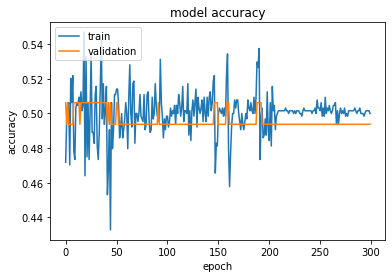

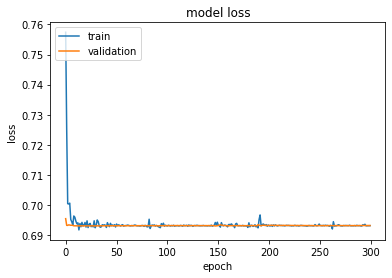

>Saved ./models/model_opt_2.h5


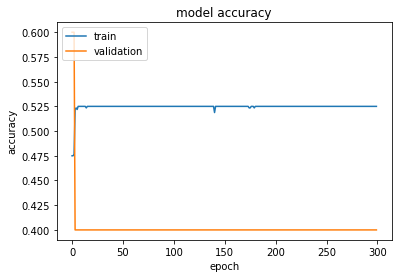

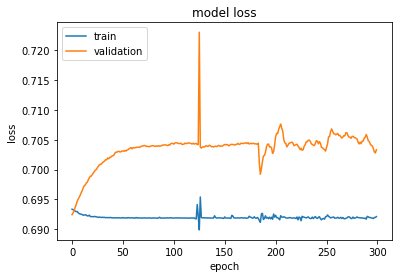

>Saved ./models/model_opt_3.h5


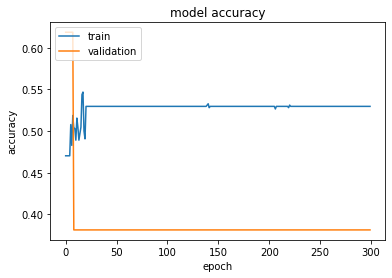

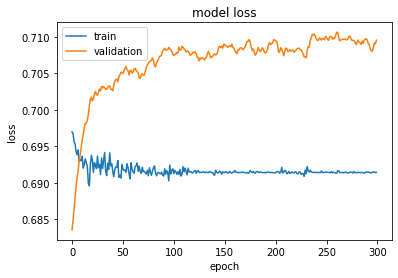

>Saved ./models/model_opt_4.h5


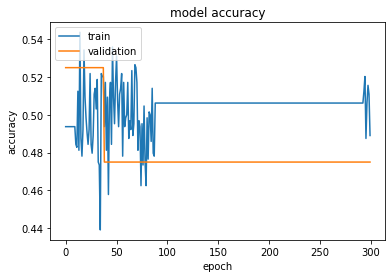

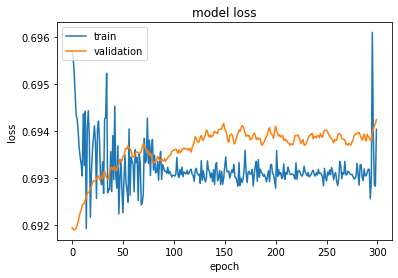

>Saved ./models/model_opt_5.h5


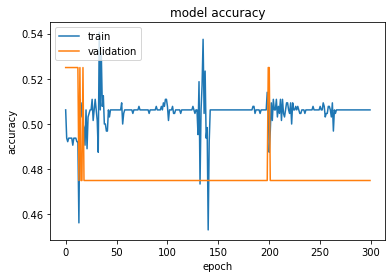

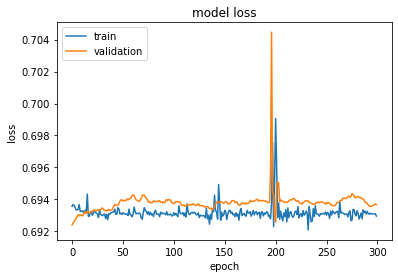

In [ ]:
model = model_LSTM()
epoch = 300
batchS = 60

for i in range(5):

    save_h5_train = './data/train_opt_dataset_'+str(i+1)+'.h5'
    save_h5_test = './data/test_opt_dataset_'+str(i+1)+'.h5'

    data_train, label_train = process_data_train(save_h5_train)
    data_test, label_test = process_data_test(save_h5_test)

    history = model.fit(np.array(data_train), np.array(label_train), epochs=epoch,
                        validation_data=(np.array(data_test), np.array(label_test)), 
                        batch_size=batchS, verbose=0)
    
    filename = './models/model_opt_'+str(i+1)+'.h5'
    model.save(filename)
    print('>Saved %s' % filename)

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('./data/model_opt_acc_'+str(i+1)+'.png')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('./data/model_opt_loss_'+str(i+1)+'.png')
    plt.show()


## Test the model

We are going to test the model with 20 % of the total videos. This videos have not been used to train the network. 

In [ ]:
save_h5_val = './data/val_kp_dataset.h5'
data_test, label_test = process_data_test(save_h5_val)

In [ ]:
len(data_test)

295

In [ ]:
# load models from file
def load_all_models(n_models):

    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'models/model_kp_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
        
    return all_models

In [ ]:
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))


>loaded models/model_kp_1.h5
>loaded models/model_kp_2.h5
>loaded models/model_kp_3.h5
>loaded models/model_kp_4.h5
>loaded models/model_kp_5.h5
Loaded 5 models


In [ ]:
# evaluate standalone models on test dataset
for model in members:
    _, acc = model.evaluate(np.array(data_test), np.array(label_test))
    print('Model Accuracy: %.3f' % acc)

10/10 [==============================] - 1s 26ms/step - loss: 0.6676 - accuracy: 0.6237
Model Accuracy: 0.624
10/10 [==============================] - 1s 25ms/step - loss: 0.6656 - accuracy: 0.6237
Model Accuracy: 0.624
10/10 [==============================] - 1s 26ms/step - loss: 0.6658 - accuracy: 0.6237
Model Accuracy: 0.624
10/10 [==============================] - 1s 26ms/step - loss: 0.6666 - accuracy: 0.6237
Model Accuracy: 0.624
10/10 [==============================] - 1s 26ms/step - loss: 0.6674 - accuracy: 0.6237
Model Accuracy: 0.624


In [ ]:
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
  
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = np.dstack((stackX, yhat))

    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape(stackX.shape[0], stackX.shape[1]*stackX.shape[2])

    return stackX

In [ ]:
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
  
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    targety = [int(x[0]) for x in inputy]
    model = LogisticRegression()
    model.fit(stackedX, targety)

    return model

In [ ]:
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):

    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    
    return yhat

In [ ]:
# fit stacked model using the ensemble
model = fit_stacked_model(members, np.array(data_test), label_test)

In [ ]:
y_test = [x[0] for x in label_test]
# evaluate model on test set
yhat = stacked_prediction(members, model, np.array(data_test))
acc = accuracy_score(y_test, yhat)*100
print(f'Stacked Test Accuracy: {acc}%')

Stacked Test Accuracy: 62.37288135593221%


In [ ]:
For keypoints
10/10 [==============================] - 1s 26ms/step - loss: 0.6676 - accuracy: 0.6237
Model Accuracy: 0.624
10/10 [==============================] - 1s 25ms/step - loss: 0.6656 - accuracy: 0.6237
Model Accuracy: 0.624
10/10 [==============================] - 1s 26ms/step - loss: 0.6658 - accuracy: 0.6237
Model Accuracy: 0.624
10/10 [==============================] - 1s 26ms/step - loss: 0.6666 - accuracy: 0.6237
Model Accuracy: 0.624
10/10 [==============================] - 1s 26ms/step - loss: 0.6674 - accuracy: 0.6237
Model Accuracy: 0.624

Stacked Test Accuracy: 62.37288135593221%

In [ ]:
For images
10/10 [==============================] - 1s 37ms/step - loss: 0.7207 - accuracy: 0.4373
Model Accuracy: 0.437
10/10 [==============================] - 1s 36ms/step - loss: 0.6940 - accuracy: 0.4949
Model Accuracy: 0.495
10/10 [==============================] - 1s 34ms/step - loss: 0.6789 - accuracy: 0.5763
Model Accuracy: 0.576
10/10 [==============================] - 1s 35ms/step - loss: 0.6424 - accuracy: 0.6102
Model Accuracy: 0.610
10/10 [==============================] - 1s 36ms/step - loss: 0.7034 - accuracy: 0.3763
Model Accuracy: 0.376

Stacked Test Accuracy: 62.37288135593221%

In [ ]:
For optical flow
10/10 [==============================] - 1s 26ms/step - loss: 0.6943 - accuracy: 0.3763
Model Accuracy: 0.376
10/10 [==============================] - 1s 26ms/step - loss: 0.6829 - accuracy: 0.6237
Model Accuracy: 0.624
10/10 [==============================] - 1s 27ms/step - loss: 0.7102 - accuracy: 0.3763
Model Accuracy: 0.376
10/10 [==============================] - 1s 26ms/step - loss: 0.6887 - accuracy: 0.6237
Model Accuracy: 0.624
10/10 [==============================] - 1s 28ms/step - loss: 0.6956 - accuracy: 0.3763
Model Accuracy: 0.376

Stacked Test Accuracy: 62.37288135593221%

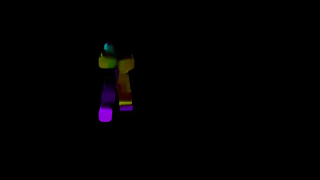

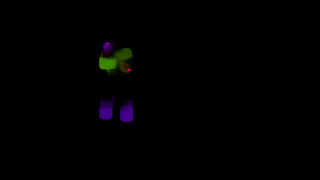

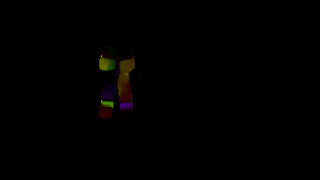

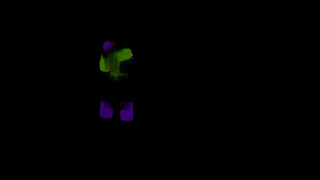

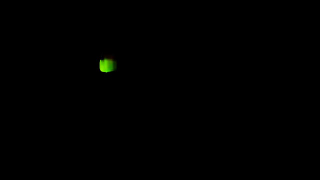

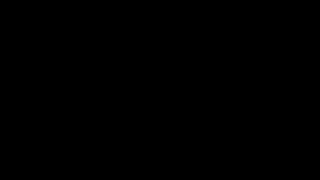

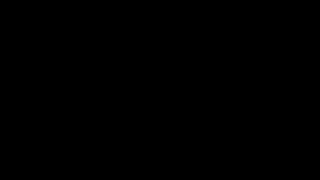

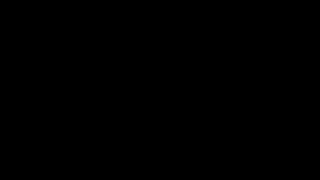

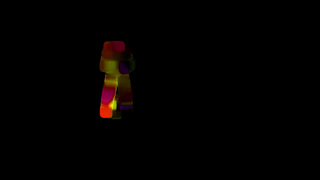

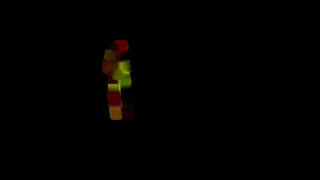

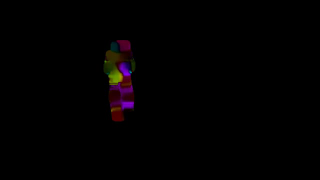

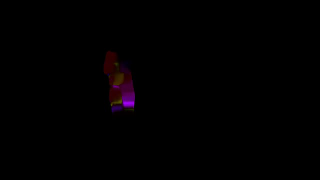

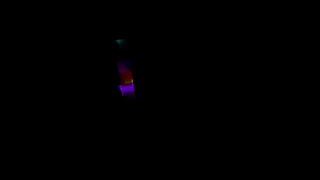

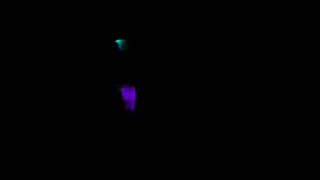

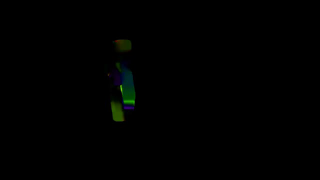

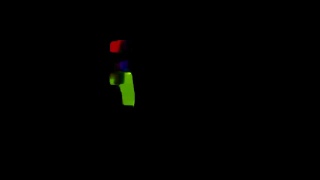

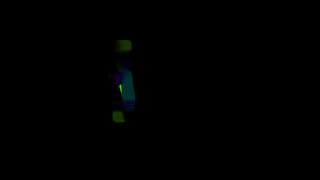

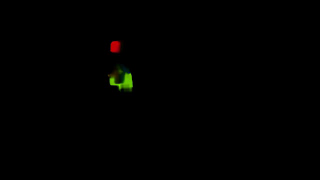

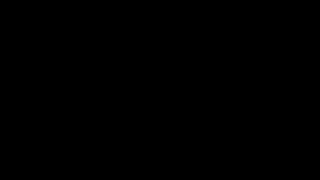

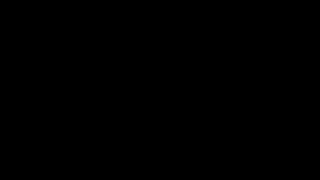

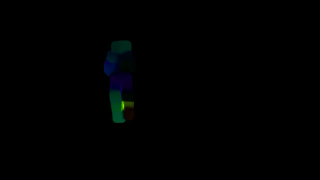

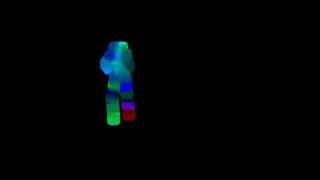

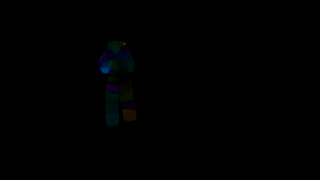

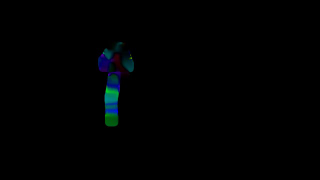

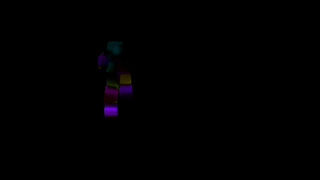

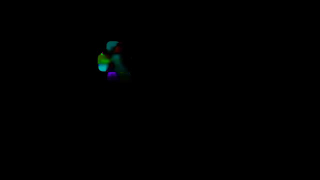

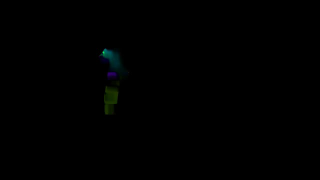

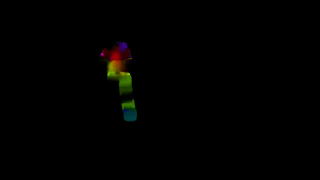

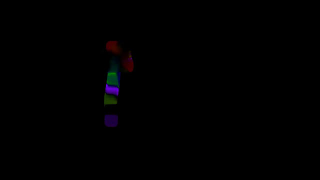

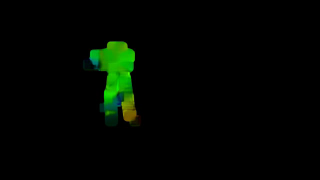

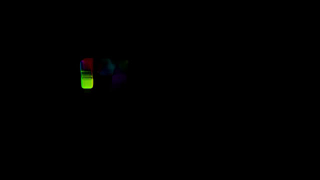

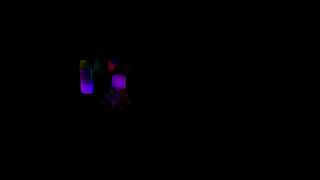

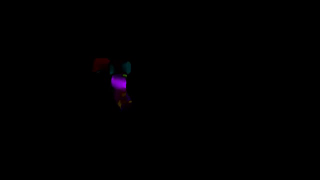

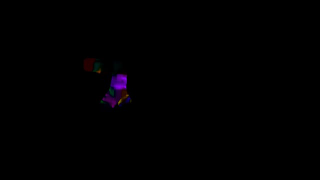

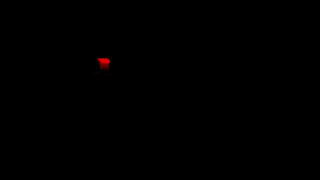

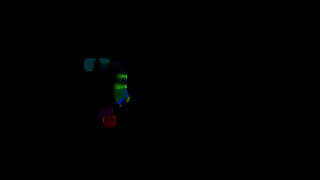

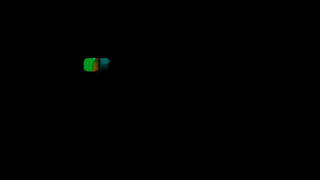

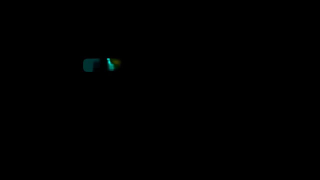

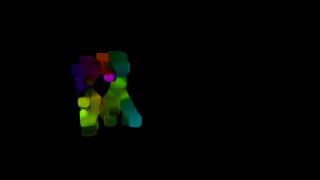

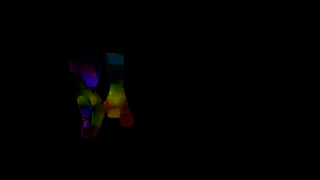

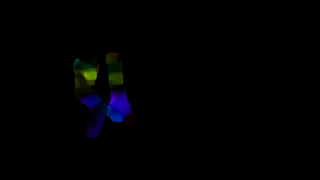

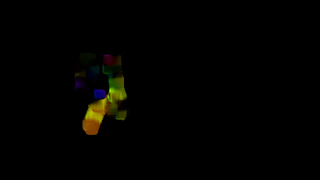

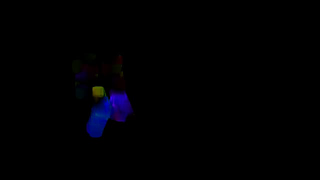

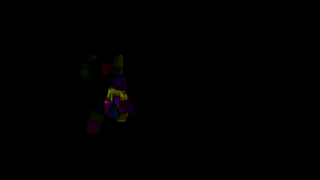

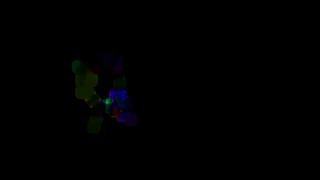

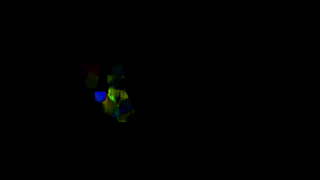

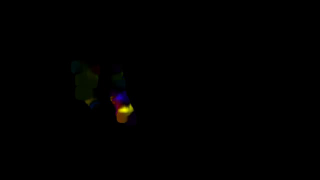

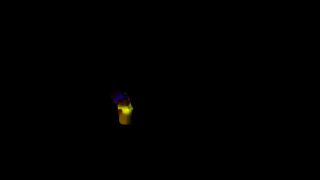

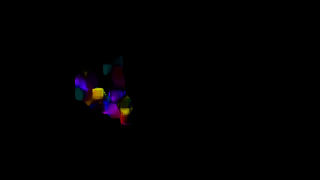

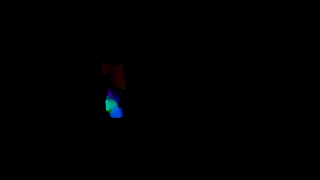

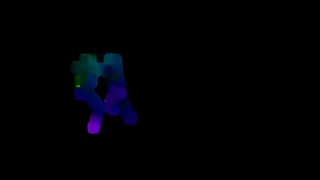

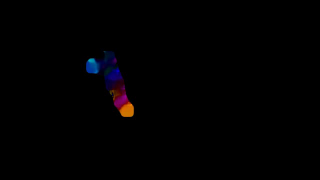

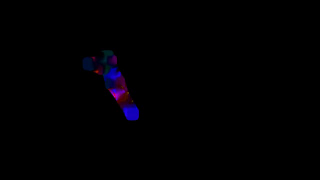

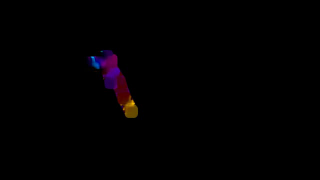

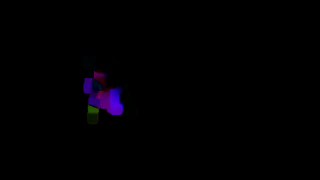

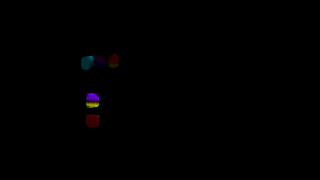

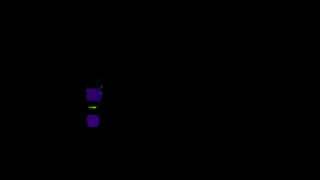

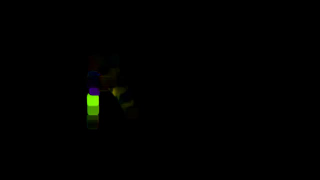

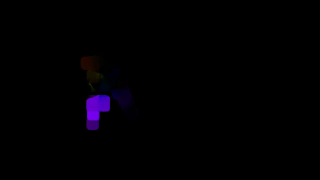

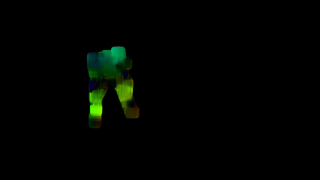

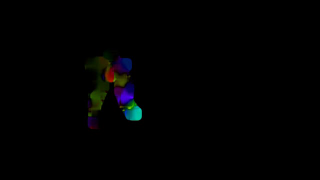

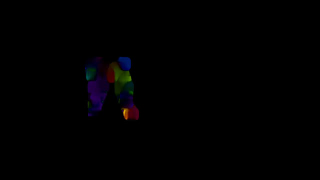

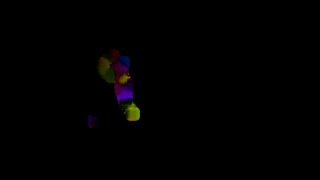

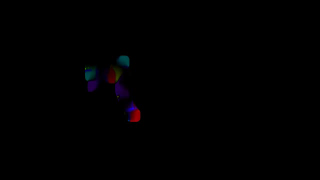

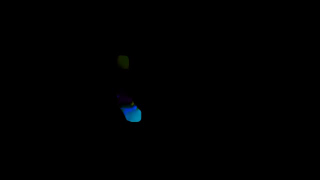

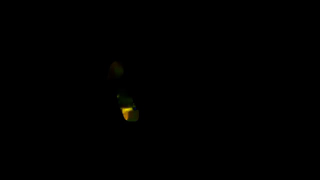

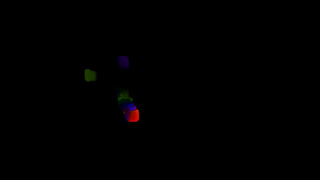

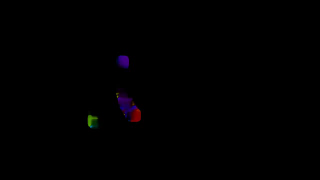

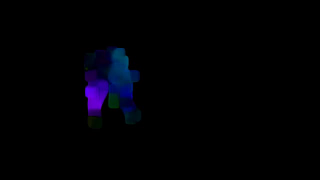

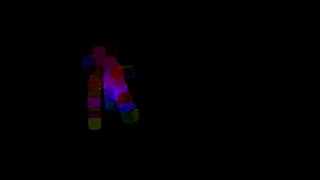

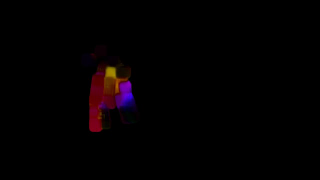

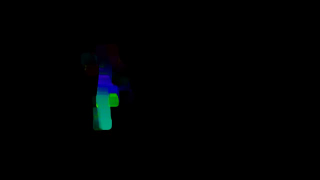

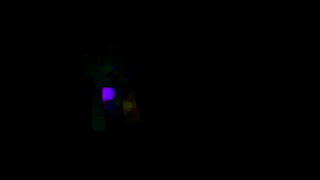

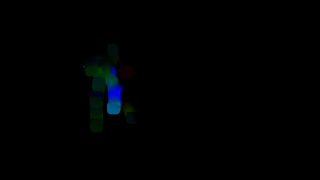

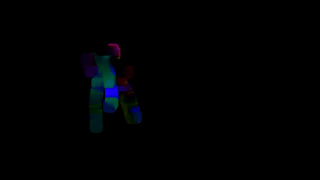

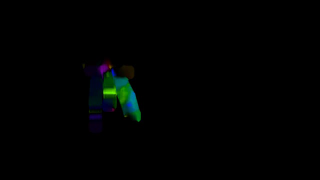

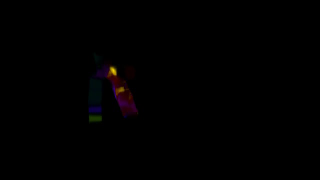

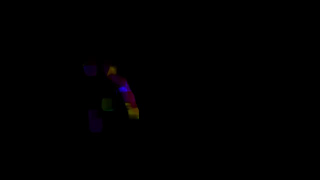

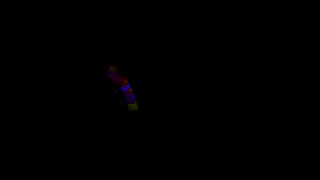

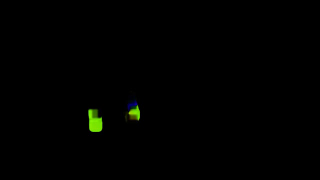

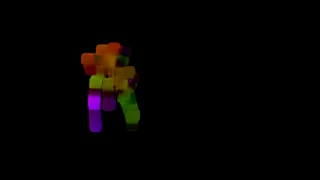

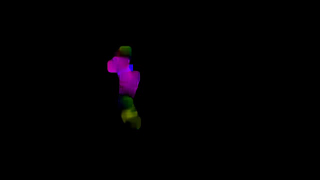

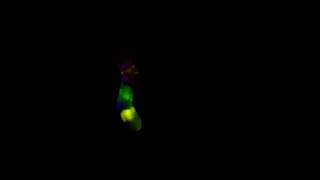

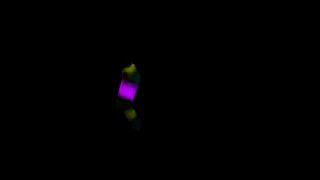

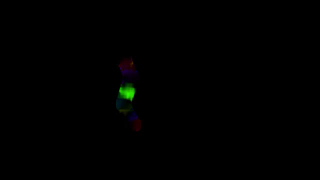

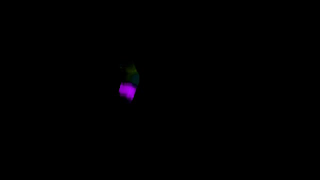

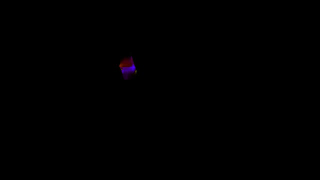

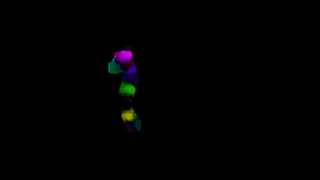

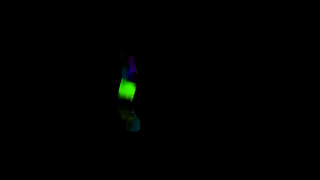

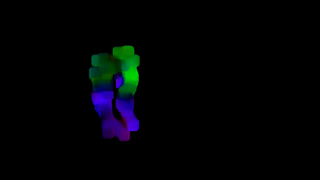

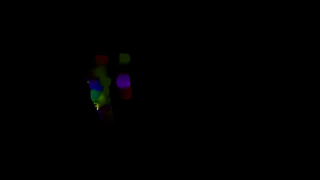

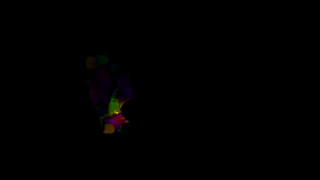

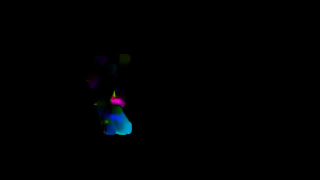

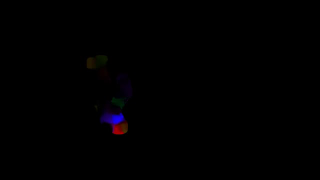

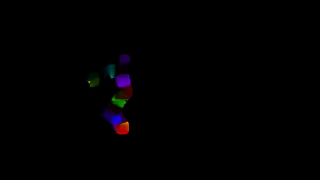

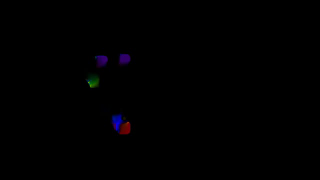

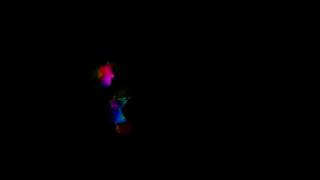

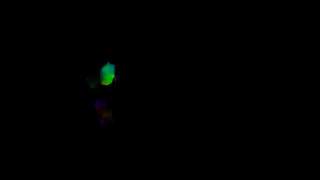

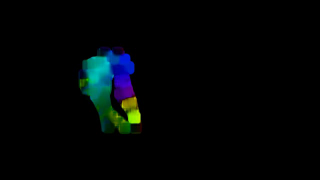

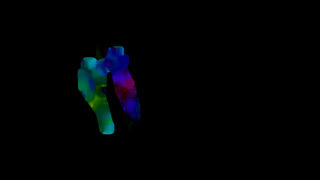

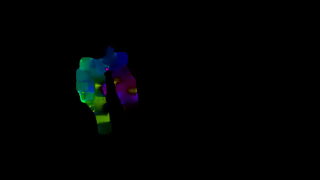

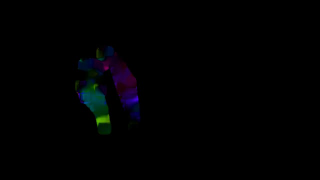

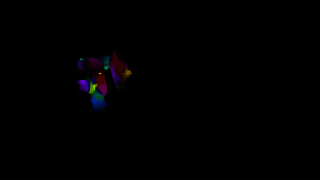

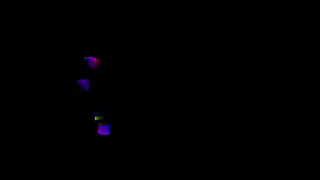

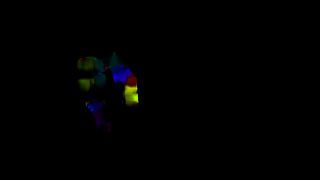

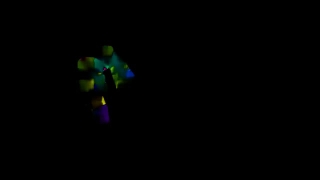

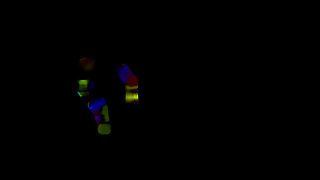

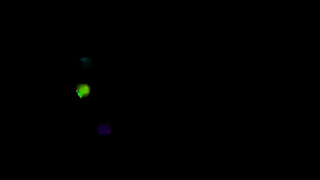

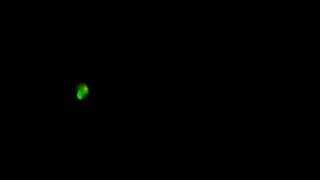

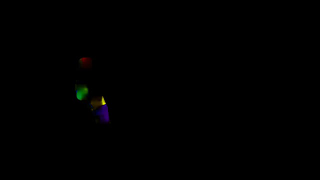

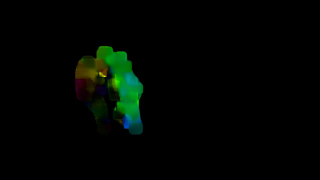

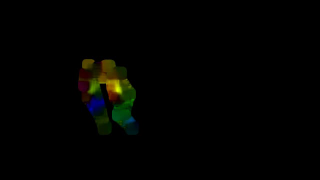

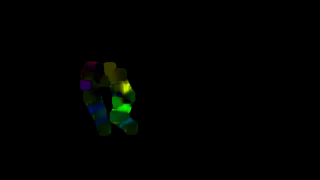

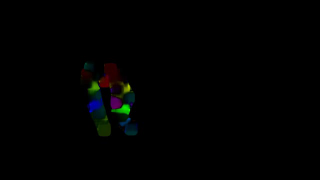

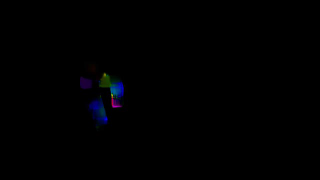

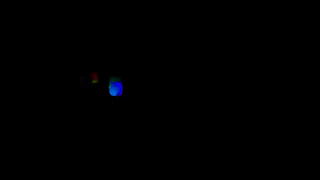

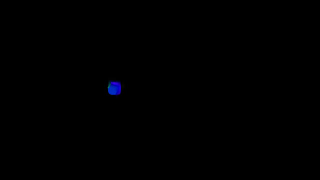

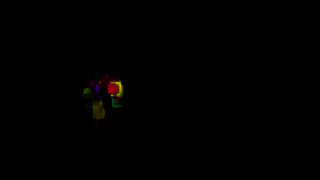

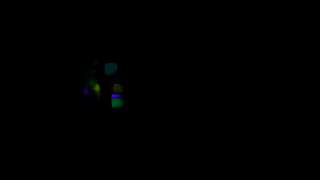

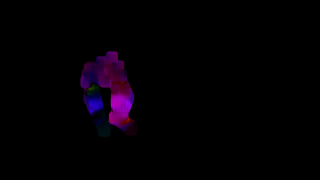

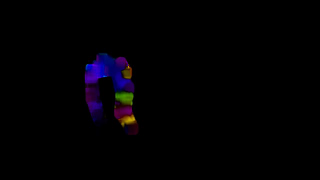

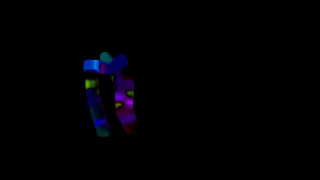

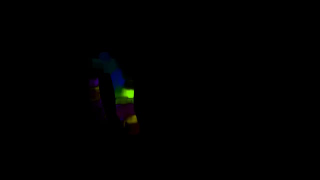

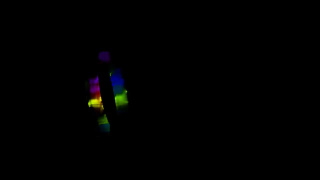

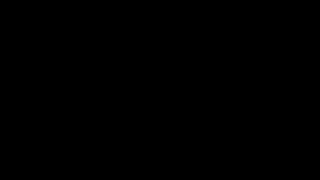

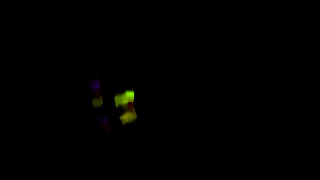

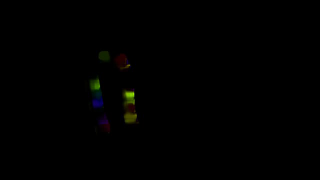

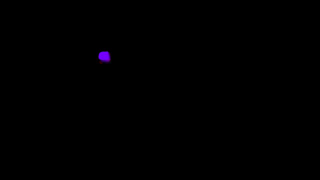

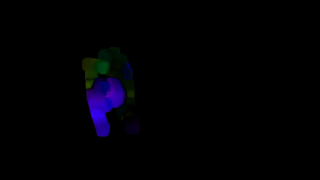

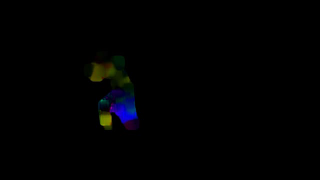

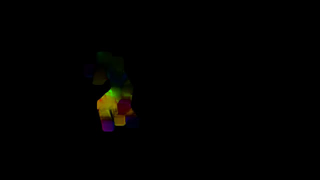

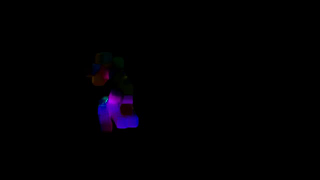

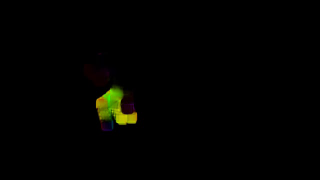

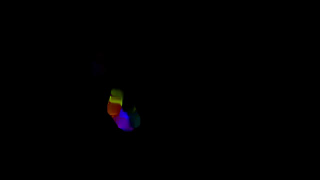

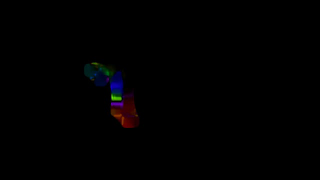

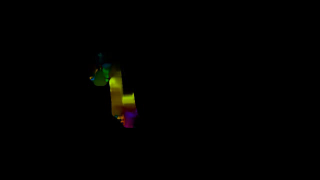

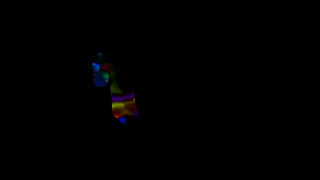

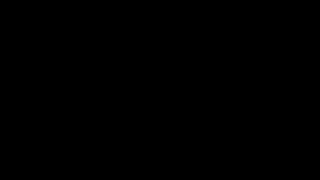

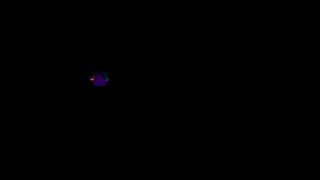

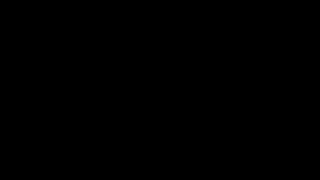

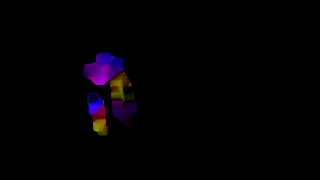

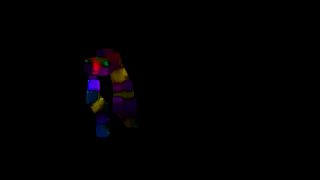

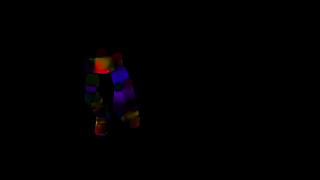

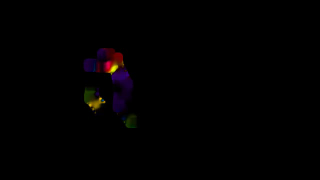

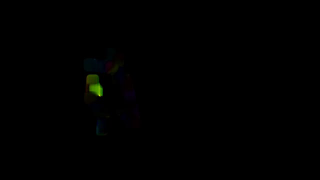

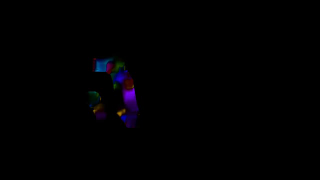

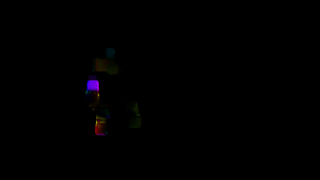

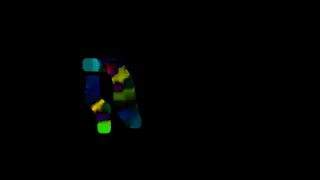

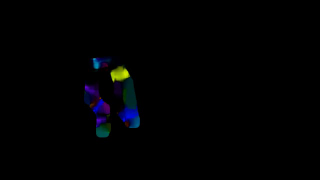

In [ ]:
from google.colab.patches import cv2_imshow
in_dir = opt_dir
vid_name = 'fi0.avi'
video_path = os.path.join(in_dir, vid_name)

cap = cv2.VideoCapture(video_path)

while cap.isOpened():

    is_success, frame = cap.read()
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    if is_success:
        frame = cv2.resize(frame,(width//2, height//2))
        cv2_imshow(frame)
    else:
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
from IPython.display import HTML
from base64 import b64encode

video_path = '../CLIP_Video_Search/media/Tom_Cruise.mp4'
mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=400 controls> <source src="{data_url}" type="video/mp4" </video>
     """)